# Imports

In [1]:
import matplotlib.pyplot as plt
from matplotlib import cm

import numpy as np
import sys
import argparse

import cv2

## Helper functions

In [2]:
def openImage(imgname):
    """
    Opens an image file and returns the image object.

    Parameters:
    imgname (str): The path to the image file.

    Returns:
    numpy.ndarray: The image object.

    """
    img = cv2.imread(imgname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [19]:
def calculate_accuracy(matches, imageKeyPoints, warpedImageKeyPoints, H):
  """
  Calculates the accuracy of the matches given key points from the original
  image, and the original image warped by the homography matrix H (using SIFT).
  Compares the warped keypoint to the image keypoint (that gets warped by H) to
  see if it is within a 3-pixel square neighborhood.

  Parameters:
  matches (cv.DMatches): The matches calculated by Brute Force match.
  imageKeyPoints (cv.KeyPoint): The original image keypoints computed by
  sift.detectAndCompute.
  warpedImageKeyPoints (cv.KeyPoint): The keypoints of the warped image computed
  by sift.detectAndCompute.
  H (np.array): 3x3 Homography matrix.

  Returns:
  int: Accuracy of the matches
  """
  hits = 0
  for eachMatch in matches:
    imageKeyPoint = imageKeyPoints[eachMatch.queryIdx].pt
    warpedKeyPoint = warpedImageKeyPoints[eachMatch.trainIdx].pt
    homogenousImageKeyPoint = np.array([imageKeyPoint[0], imageKeyPoint[1], 1])
    warpedImagePoint = H @ homogenousImageKeyPoint
    warpedImagePoint = warpedImagePoint/warpedImagePoint[2]
    warpedImagePoint = warpedImagePoint[:2]

    if np.abs(warpedImagePoint[0] - warpedKeyPoint[0]) <= 3 and np.abs(warpedImagePoint[1] - warpedKeyPoint[1]) <= 3:
      hits += 1
  return hits/len(matches)

In [7]:
def computeMatches(img1, img2, img3):
  """
  Computes the keypoints of img1, img2, img3 using sift.detectAndCompute. Then,
  matches keypoints in img1 and img2. Also matches keypoints in img2 and img3.

  Parameters:
  img1 (np.array): First image.
  img2 (np.array): Second image.
  img3 (np.array): Third image.

  Returns:
  keypointList (list[cv.KeyPoints]): List of keypoints. keypointList[0] stores
  img1 keypoints, etc.
  matches12 (cv.DMatch): Matches of img1 and img2 keypoints.
  matches23 (cv.DMatch): Matches of img2 and img3 keypoints.
  """
  keypointList = []
  descriptorList = []

  sift = cv2.SIFT_create()

  for img in [img1,img2,img3]:
    grayImage = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kp, des = sift.detectAndCompute(grayImage, None)
    keypointList.append(kp)
    descriptorList.append(des)


  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
  matches12 = bf.match(descriptorList[0],descriptorList[1])
  matches23 = bf.match(descriptorList[1],descriptorList[2])

  matches12 = sorted(matches12, key = lambda x:x.distance)
  matches23 = sorted(matches23, key = lambda x:x.distance)
  return keypointList, matches12, matches23

# Question 1

Open the image, initialize the H matrix

In [3]:
image = openImage("IMG_8833.JPG")
H = np.array([[1.5, 0.5, 0], [0,2.5,0], [0,0,1]])
length, width, channels = image.shape

Use H matrix to warp the image.

In [4]:
warpedImage = cv2.warpPerspective(image, H, (length*2, width*2))
sift = cv2.SIFT_create()

Use sift.detectAndCompute to compute the keypoints. It takes a grayscale image, and uses Scale Invariant Feature Transform to identify keypoints.

It does this by using Difference of Gaussians (DoG) to find points of interest, then uses keypoint localization (similar to Harris Corner Detection) to discard some of the points of interest that are not corners or sufficiently intense.

Then, it assigns orientation of the keypoint by taking a neighborhood, calculating the gradient of the point, and calculating the magnitude and direction. It adds all the directions to a histogram, weighed with the magnitude. Then, it chooses the direction with the highest magnitude. This guarantees rotation invariance.

Finally, it creates the keypoint descriptors.

In [5]:
grayImage = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
imageKeyPoints, des = sift.detectAndCompute(grayImage,None)

Brute force matches the keypoints by calculating the euclidean distance between each of the image keypoints and warpedImage keypoints, and selecting the image keypoint and warpedImage keypoint that has the smallest distance.

In [6]:
grayWarpedImage = cv2.cvtColor(warpedImage, cv2.COLOR_RGB2GRAY)
warpedImageKeyPoints, warpDes = sift.detectAndCompute(grayWarpedImage, None)

In [8]:
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des,warpDes)
matches = sorted(matches, key = lambda x:x.distance)

Calculate accuracy

In [18]:
acc = calculate_accuracy(matches, imageKeyPoints, warpedImageKeyPoints, H)
print(acc)

21665
0.5061158550657743


Its interesting to see that even for such a well-known algorithm, the accuracy is not that great.

# Question 2

Open the images

In [8]:
img1 = openImage("IMG_8833.JPG")
img2 = openImage("IMG_8834.JPG")
img3 = openImage("IMG_8835.JPG")

Triple the width of each image, so it's easy to stitch all the images together. The image isn't being resized, it is simple being placed on a bigger canvas

In [16]:
img1Bigger = np.zeros((img1.shape[0], img1.shape[1]*3, img1.shape[2]), dtype=np.uint8)
img2Bigger = np.zeros((img2.shape[0], img2.shape[1]*3, img2.shape[2]), dtype=np.uint8)
img3Bigger = np.zeros((img3.shape[0], img3.shape[1]*3, img3.shape[2]), dtype=np.uint8)

In [17]:
img1Bigger[:, :img1.shape[1], :] = img1
img2Bigger[:, img1.shape[1]:img1.shape[1]*2, :] = img2
img3Bigger[:, img1.shape[1]*2:, :] = img3

In [18]:
img1 = img1Bigger
img2 = img2Bigger
img3 = img3Bigger

Find the keypoints of each image, and then compute the keypoint matches of img1 and img2, as well as img2 and img3

In [19]:
kpList, match1, match2 = computeMatches(img1, img2, img3)

In [20]:
match1 = sorted(match1, key = lambda x:x.distance)
match2 = sorted(match2, key = lambda x:x.distance)

Get the matching keypoints for img1 and img2

In [21]:
img1toimg2keyPoints = np.array([list(kpList[0][eachMatch.queryIdx].pt) for eachMatch in match1[:200]]).reshape(-1, 1, 2)

In [22]:
img2keyPoints = np.array([list(kpList[1][eachMatch.trainIdx].pt) for eachMatch in match1[:200]]).reshape(-1, 1, 2)

Find the homography matrix between img1 and img2 based on the matching img1 and img2 keypoints. This is done using the RANSAC algorithm.

The RANSAC algorithm works in the following way:
1. Choose a subset of the keypoints, called the 'consensus set'.
2. Compute the homography matrix.
3. Calculate loss of keypoints not included in the original subset, based on the computed homography matrix .
4. Include keypoints that have a small enough loss in the 'consensus set'.
5. If enough keypoint are now in the consensus set, calculate a new matrix based on all the points in the consensus set.
6. Check if this is better than the original matrix.
7. Repeat this k times

In [40]:
H = cv2.findHomography(img1toimg2keyPoints, img2keyPoints, cv2.RANSAC, 5.0)[0]

In [41]:
length, width, channels = img1.shape

Warp img1 based on the homography that we calculated.

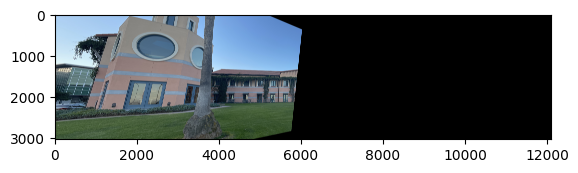

In [46]:
warpedImgq = cv2.warpPerspective(img1, H, (width, length))
plt.imshow(warpedImgq)

Blend the warped img1 and img2, giving preference img1

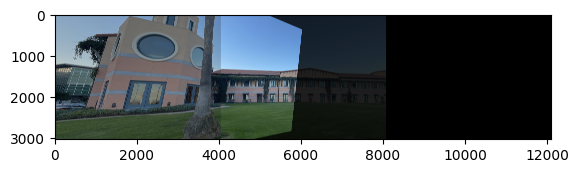

In [55]:
alpha = 0.8  # blending factor
blended_image1 = cv2.addWeighted(warpedImgq, alpha, img2, 1 - alpha, 0)
plt.imshow(blended_image1)

Repeat the same steps above to warp img3 to be aligned with img2, and then blend them together

In [29]:
img3kp = np.array([list(kpList[2][eachMatch.trainIdx].pt) for eachMatch in match2[:200]]).reshape(-1, 1, 2)
img2kp = np.array([list(kpList[1][eachMatch.queryIdx].pt) for eachMatch in match2[:200]]).reshape(-1, 1, 2)

In [31]:
H = cv2.findHomography(img3kp, img2kp, cv2.RANSAC, 5.0)[0]
length, width, channels = img3.shape

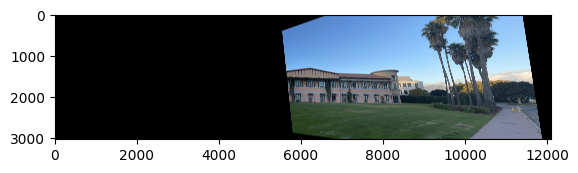

In [36]:
warpedImg3 = cv2.warpPerspective(img3, H, (width, length))
plt.imshow(warpedImg3)

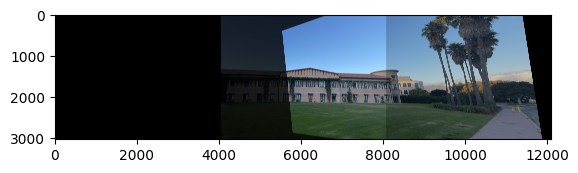

In [57]:
alpha = 0.8  # blending factor
blended_image2 = cv2.addWeighted(warpedImg3, alpha, img2, 1-alpha, 0)
plt.imshow(blended_image2)

Blend the 2 blended images together to create the final panoramic image.

In [58]:
panaromicImg = cv2.addWeighted(blended_image1, 0.5, blended_image2, 0.5, 0)

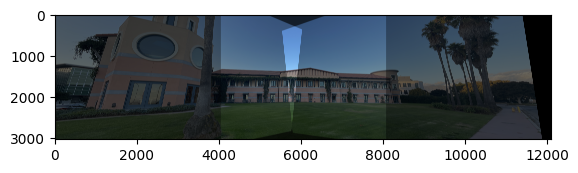

In [59]:
plt.imshow(panaromicImg)